- Dataset : http://vis-www.cs.umass.edu/lfw/#download

- Dataset Structure :

```
DATASET\
    label_name_A\
        label_name_A_001.jpg
        label_name_A_002.jpg
        label_name_A_003.jpg
        .
        .
    label_name_B\
        label_name_B_001.jpg
        label_name_B_002.jpg
        label_name_B_003.jpg
        .
        .
```

In [100]:
import os 
import cv2 
import numpy as np
import matplotlib.pyplot as plt


# disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [101]:
#Path to the root image directory containing sub-directories of images
dataset_folder = "DATASET"

data_slice = [70, 195, 78, 172] 
# [ymin, ymax, xmin, xmax]
# to extract the `interesting` part of the image files 
# and avoid use statistical correlation from the background 

# resize ratio to reduce sample dimension
resize_ratio = 2.5

h = int((data_slice[1] - data_slice[0])/resize_ratio) #ymax - ymin slice, Height of image in float
w = int((data_slice[3] - data_slice[2])/resize_ratio) #xmax - xmin slice, Width of image in float 
print("Image dimension after resize (h,w) :", h, w)

Image dimension after resize (h,w) : 50 37


In [102]:
# minimum number of sample for each class
sample_class = 100
class_name = []

for folder in os.listdir(dataset_folder):
    if len(os.listdir(os.path.join(dataset_folder, folder))) >= sample_class:
        class_name.append(folder)

In [103]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val, folder), end="\r")

In [104]:
# preprocessin data using OpenCV
imgs = []
labels = []
for folder in class_name:
    folder_files = os.listdir(os.path.join(dataset_folder, folder))
    len_sub_folder = len(folder_files) - 1
    for i, filename in enumerate(folder_files):
        img = cv2.imread(os.path.join(dataset_folder, folder, filename))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        croped = gray[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
        resized = cv2.resize(croped, (w,h))
        imgs.append(resized)
        labels.append(folder)
        
        print_progress(i, len_sub_folder, folder)


[####################] (235 samples)	 label : Colin_Powell 		
[####################] (120 samples)	 label : Donald_Rumsfeld 		
[####################] (529 samples)	 label : George_W_Bush 		
[####################] (108 samples)	 label : Gerhard_Schroeder 		
[####################] (143 samples)	 label : Tony_Blair 		


In [105]:
print("Number of samples \t: ", len(labels))
print("Number of class \t: ", len(class_name))
print("Class name \t\t: \n", class_name)

Number of samples 	:  1250
Number of class 	:  6
Class name 		: 
 ['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Yunus']


In [106]:
# test preview image in index 0
cv2.imshow("preview sample image", imgs[300])

cv2.waitKey(0)
cv2.destroyAllWindows()

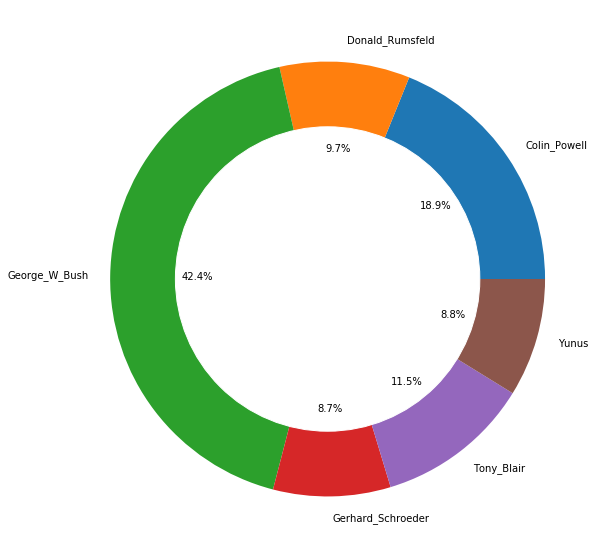

In [107]:
# preview data distribution

def print_data(label_distr, label_name):
    plt.figure(figsize=(20,10))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, 
            labels=label_name,  
            autopct='%1.1f%%')

    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()
    
label_distr = {i:labels.count(i) for i in labels}.values()
print_data(label_distr, class_name)

### Balancing dataset

In [108]:
# reduce sample size per-class using numpy random choice
n = sample_class

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(labels, l) for l in np.unique(labels)])

In [109]:
balanced_labels = [labels[m] for m in mask]
balanced_imgs = [imgs[m] for m in mask]

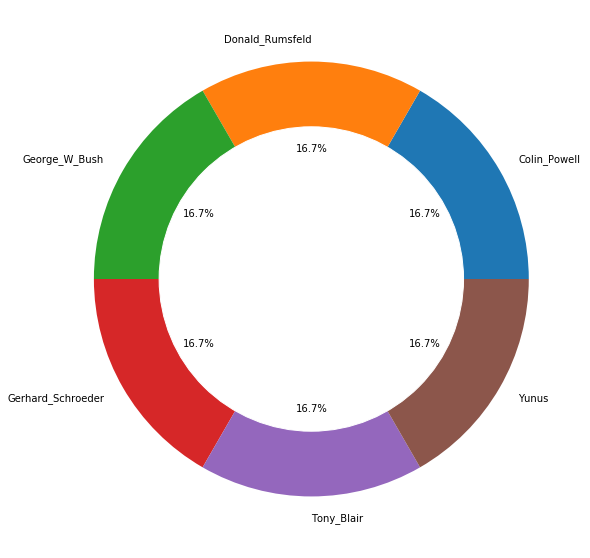

In [110]:
label_distr = {i:balanced_labels.count(i) for i in balanced_labels}.values()
print_data(label_distr, class_name)

### Prepare Dataset

In [111]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [112]:
X = np.array(balanced_imgs)

#### Label encoding & categoricalize output vector

In [113]:
le = LabelEncoder()
le.fit(balanced_labels)
le.classes_

array(['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush',
       'Gerhard_Schroeder', 'Tony_Blair', 'Yunus'], dtype='<U17')

In [114]:
class_name

['Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Tony_Blair',
 'Yunus']

In [115]:
Y = le.transform(balanced_labels)
Y = to_categorical(Y)

#### Split dataset

In [116]:
X_train, X_test, y_train, y_test = \
                    train_test_split(X, 
                                     Y, 
                                     test_size=0.25, 
                                     random_state=42)
  
print("Dimensi data :\n")
print("X train \t X test \t Y train \t Y test")  
print("%s \t %s \t %s \t %s" % (X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Dimensi data :

X train 	 X test 	 Y train 	 Y test
(450, 50, 37) 	 (150, 50, 37) 	 (450, 6) 	 (150, 6)


### Build CNN Model

In [117]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, Flatten, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [118]:
def resize_data(X_train, X_test):
    #
    # 4+D tensor with shape: batch_shape + (channels, rows, cols) if data_format='channels_first' or 
    # 4+D tensor with shape: batch_shape + (rows, cols, channels) if data_format='channels_last'.
    #
    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
        # print(X_train.shape)
        input_shape = (1, X_train.shape[1], X_train.shape[2])
    else:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
        # print(X_train.shape)
        input_shape = (X_train.shape[1], X_train.shape[2], 1)
    return X_train, X_test, input_shape 

In [119]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [126]:
def cnn_model(image_shape, output_size):
    opt = Adam() #learning_rate=0.001
    
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=image_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
              
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dropout(0.2))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(output_size))
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer=opt, 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy', precision, recall])

    return model

In [127]:
X_train, X_test, input_shape = resize_data(X_train, X_test)

EPOCHS = 40
BATCH_SIZE = 64

model = cnn_model(input_shape, len(class_name))


callbacks = [EarlyStopping(monitor='val_loss', patience=7),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
history = model.fit(X_train, 
                      y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      callbacks=callbacks,
                      validation_data=(X_test,y_test))

model.load_weights('best_model.h5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 48, 35, 64)        640       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 46, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 23, 16, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 23, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 21, 14, 128)       73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 19, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 9, 6, 128)        

450/450 [==============================] - 8s 17ms/step - loss: 0.1579 - accuracy: 0.9533 - precision: 0.9590 - recall: 0.9627 - val_loss: 0.8154 - val_accuracy: 0.7933 - val_precision: 0.7737 - val_recall: 0.7901
Epoch 28/40
450/450 [==============================] - 8s 17ms/step - loss: 0.1403 - accuracy: 0.9533 - precision: 0.8965 - recall: 0.8983 - val_loss: 0.7845 - val_accuracy: 0.8467 - val_precision: 0.8153 - val_recall: 0.8292
Epoch 29/40
450/450 [==============================] - 8s 17ms/step - loss: 0.4525 - accuracy: 0.8333 - precision: 0.7480 - recall: 0.8108 - val_loss: 0.7162 - val_accuracy: 0.7800 - val_precision: 0.7017 - val_recall: 0.7746
Epoch 30/40
450/450 [==============================] - 8s 17ms/step - loss: 0.5732 - accuracy: 0.8067 - precision: 0.8203 - recall: 0.8507 - val_loss: 0.6188 - val_accuracy: 0.7800 - val_precision: 0.7022 - val_recall: 0.7982
Epoch 31/40
450/450 [==============================] - 7s 16ms/step - loss: 0.4161 - accuracy: 0.8467 - prec

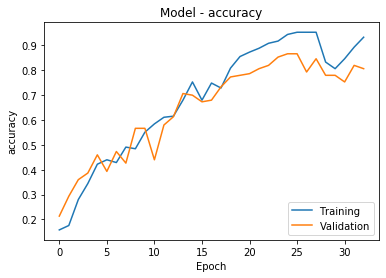

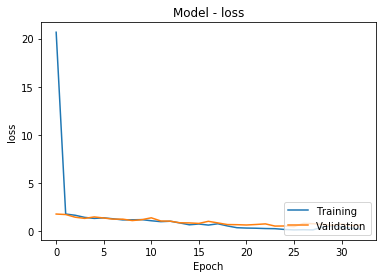

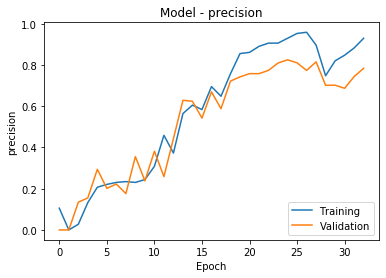

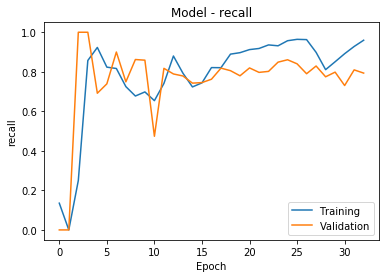

In [128]:
def evaluate_model(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss'], 
             ['precision', 'val_precision'], 
             ['recall', 'val_recall']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.show()
        
evaluate_model(history)

In [129]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

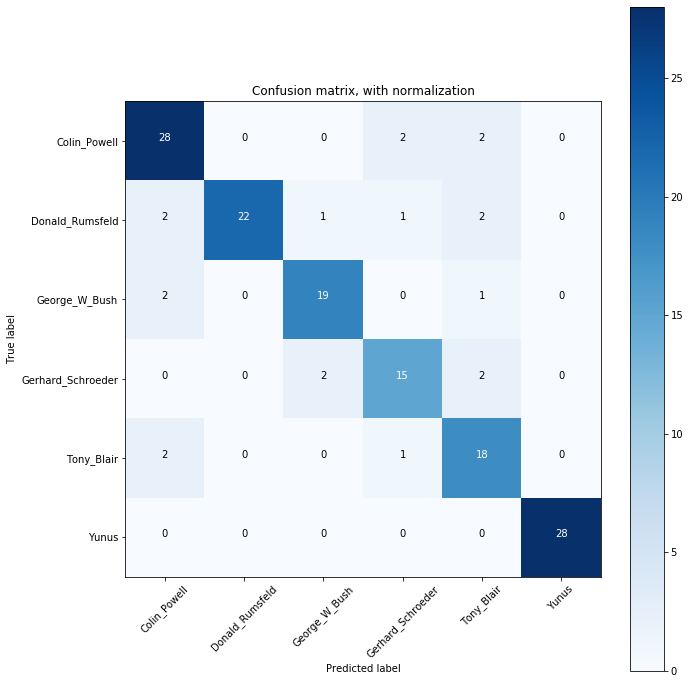

In [130]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      classes=class_name,
                      normalize=False,
                      title='Confusion matrix, with normalization')


In [131]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=class_name))

                   precision    recall  f1-score   support

     Colin_Powell       0.82      0.88      0.85        32
  Donald_Rumsfeld       1.00      0.79      0.88        28
    George_W_Bush       0.86      0.86      0.86        22
Gerhard_Schroeder       0.79      0.79      0.79        19
       Tony_Blair       0.72      0.86      0.78        21
            Yunus       1.00      1.00      1.00        28

         accuracy                           0.87       150
        macro avg       0.87      0.86      0.86       150
     weighted avg       0.88      0.87      0.87       150



## Model Inference Test

In [193]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

cap.set(3,640)
cap.set(4,480)

while(True):
    # Capture frame-by-frame
    test = []
    face = []
    ret, frame = cap.read()
    xv, yv, cv = frame.shape
    if ret == True :
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        try :
            for (x,y,wf,hf) in faces:
                cy, cx = y + (hf//2), x + (wf//2)
                max_len = max(hf,wf) + 70

                if (x - max_len) <= 0 or (x + max_len) >= xv or (y - max_len) <= 0 or (y + max_len) >= yv :
                    continue

                # preprocessing
                face_crop = gray[cy-max_len:cy+max_len, cx-max_len:cx+max_len]
                face_crop = cv2.resize(face_crop, (250,250))
                face_crop = face_crop[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
                FaceImage = cv2.resize(face_crop, (w,h))
                cv2.imshow("face", FaceImage)
                
                FaceImage, __, __ = resize_data(np.array([FaceImage]), np.array([FaceImage]))

                # predict image
                predicted_obj = model.predict(FaceImage)
                predicted_class = class_name[np.argmax(predicted_obj)]
                confidence_level = np.round(np.max(predicted_obj), 3)*100.0

                # print(predicted_obj, end="\r")         

                if confidence_level >= 70 :
                    # create box on detected face
                    frame = cv2.rectangle(frame,(cx-max_len,cy-max_len),(cx+max_len,cy+max_len),(0,0,255),1)

                    frame = cv2.rectangle(frame,(x,y),(x+wf,y+hf),(255,0,0),1)
                    frame = cv2.rectangle(frame,(x,y+hf),(x+wf,y+hf+30),(255,0,0),-1)

                    # print label name on image
                    cv2.putText(frame,
                                "%s (%.1f)" % (predicted_class, confidence_level),
                                (x + x//10, y+hf+20),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.4,
                                (255, 255, 255), 1)
            cv2.imshow('frame',frame)
        except:
            cv2.imshow('frame',frame)
        
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


In [175]:
cap.release()
cv2.destroyAllWindows()

In [145]:
data_slice

[70, 195, 78, 172]